##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons 画像 : 操作

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/addons/tutorials/image_ops"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/addons/tutorials/image_ops.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/addons/tutorials/image_ops.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
      <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/addons/tutorials/image_ops.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## 概要

このノートブックでは、TensorFlow Addons で画像操作を使用する方法をいくつか紹介します。

この例で説明する画像操作のリストは以下の通りです。

- `tfa.image.mean_filter2d`

- `tfa.image.rotate`

- `tfa.image.transform`

- `tfa.image.random_hsv_in_yiq`

- `tfa.image.adjust_hsv_in_yiq`

- `tfa.image.dense_image_warp`

- `tfa.image.euclidean_dist_transform`

# セットアップ

In [2]:
!pip install -q -U tensorflow-addons

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

# 画像を準備して検査する

## 画像をダウンロードする

In [4]:
img_path = tf.keras.utils.get_file('tensorflow.png','https://tensorflow.org/images/tf_logo.png')

 8192/39781 [=====>........................] - ETA: 0s

16384/39781 [===========>..................] - ETA: 0s

40960/39781 [==============================] - 0s 3us/step


## 画像を検査する

### TensorFlow のアイコン

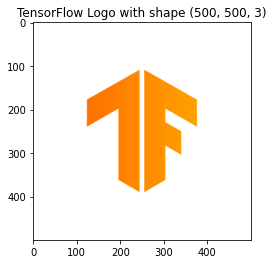

In [5]:
img_raw = tf.io.read_file(img_path)
img = tf.io.decode_image(img_raw)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [500,500])

plt.title("TensorFlow Logo with shape {}".format(img.shape))
_ = plt.imshow(img)

### 白黒バージョンを作成する

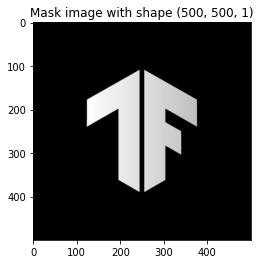

In [6]:
bw_img = 1.0 - tf.image.rgb_to_grayscale(img)

plt.title("Mask image with shape {}".format(bw_img.shape))
_ = plt.imshow(bw_img[...,0], cmap='gray')

# tfa.image を使って遊ぶ

## 平均フィルタリング

平均フィルタリングはフィルタリング技術の 1 つで、画像や信号のノイズ除去によく使用されます。この考え方は、画像をピクセル単位で処理し、隣接するピクセルの平均値で置き換えるというものです。

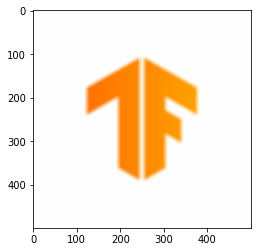

In [7]:
mean = tfa.image.mean_filter2d(img, filter_shape=11)
_ = plt.imshow(mean)

## 回転

この操作は、特定の画像をユーザーが入力した角度（ラジアン単位）に回転させます。 

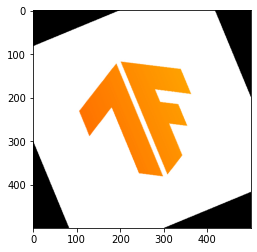

In [8]:
rotate = tfa.image.rotate(img, tf.constant(np.pi/8))
_ = plt.imshow(rotate)

## 変換

この操作は、特定の画像をユーザーが指定した変換ベクトルに基づいて変換します。 

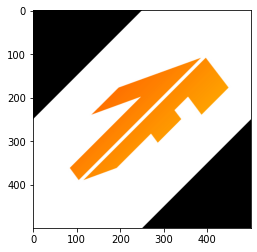

In [9]:
transform = tfa.image.transform(img, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
_ = plt.imshow(transform)

## YIQ でランダムに HSV 変換する

この操作は、特定の RGB 画像のカラースケールを YIQ に変更しますが、ここではデルタ色相と彩度の値を指定された範囲からランダムに選択します。

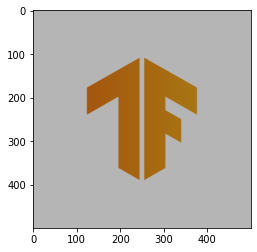

In [10]:
delta = 0.5
lower_saturation = 0.1
upper_saturation = 0.9
lower_value = 0.2
upper_value = 0.8
rand_hsvinyiq = tfa.image.random_hsv_in_yiq(img, delta, lower_saturation, upper_saturation, lower_value, upper_value)
_ = plt.imshow(rand_hsvinyiq)

## YIQ で HSV を調整する

この操作は、特定の RGB 画像のカラースケールを YIQ に変更しますが、ここではランダムに選択するのではなく、デルタ色相と彩度の値はユーザーの入力値です。

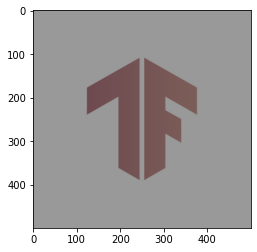

In [11]:
delta = 0.5
saturation = 0.3
value = 0.6
adj_hsvinyiq = tfa.image.adjust_hsv_in_yiq(img, delta, saturation, value)
_ = plt.imshow(adj_hsvinyiq)

## 高密度画像ワープ

この操作は、オフセットベクトルのフローフィールドで指定された任意の画像の非線形ワープを行います（例えば、ここではランダムな値を使用します）。 

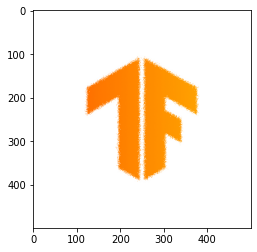

In [12]:
input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)

flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
init_flows = np.float32(np.random.normal(size=flow_shape) * 2.0)
dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
dense_img_warp = tf.squeeze(dense_img_warp, 0)
_ = plt.imshow(dense_img_warp)

## ユークリッド距離変換

この操作は、前景ピクセルから背景ピクセルまでのピクセル値をユークリッド距離で更新します。

- 注意: これは二値化画像のみを受け取り、結果は変換された画像になります。異なる画像を指定した場合は、結果は単一の値の画像になります。

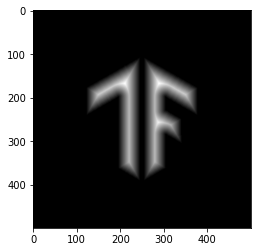

In [13]:
gray = tf.image.convert_image_dtype(bw_img,tf.uint8)
# The op expects a batch of images, so add a batch dimension
gray = tf.expand_dims(gray, 0)
eucid = tfa.image.euclidean_dist_transform(gray)
eucid = tf.squeeze(eucid, (0, -1))
_ = plt.imshow(eucid, cmap='gray')